In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import rank2d

In [3]:
grid_search_enable = True
cv = 2
verbose = 3
number_of_jobs = -1
rand_state = 101

In [4]:
bdf = pd.read_csv("featured_bank_imputed_wo_duration_year.csv")

### Feature engineering

In [5]:
def festivals(month):
    # imputing festivals - apr: easter; jun:carnival; dec:christmas
    if month == 'apr' or month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [6]:
bdf['f.festivals'] = bdf['month'].apply(festivals)

In [7]:
def bonus_months(month):
    # bonus paid twice in a year - may and nov
    if month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [8]:
bdf['f.bonus_months']= bdf['month'].apply(bonus_months)

In [9]:
def commitment(housing, personal, marital):
    # if a person is married and has housing and personal loans, flag it as high commitment
    if housing == 'yes' and personal == 'yes' and marital == 'married':
        return "high"
    if housing == 'no' and personal == 'no' and marital in ['single']:
        return "low"
    else:
        return "medium"

In [10]:
bdf['f.commitment'] = bdf.apply(lambda x: commitment(x.housing, x.loan, x.marital), axis=1)

In [11]:
def seasons(month):
    if month in ['mar','apr','may']:
        return 'spring'
    if month in ['jun','jul','aug']:
        return 'summer'
    if month in ['sep','oct','nov']:
        return 'autumn'
    if month in ['dec','jan','feb']:
        return 'winter'

In [12]:
bdf['f.seasons'] = bdf['month'].apply(lambda mon: seasons(mon))

In [13]:
def seasons_weightage(season):
    if season == 'autumn':
        return 21
    if season == 'spring':
        return 36
    if season == 'summer':
        return 40
    if season == "winter":
        return 2

In [14]:
bdf ['f.season_weight'] = bdf['f.seasons'].apply(lambda season: seasons_weightage(season))

In [15]:
def retired(age):
    if age >= 65:
        return 'retired'
    else:
        return 'not-retired'

In [16]:
bdf['f.retired_status'] = bdf['age'].apply(lambda age: retired(age))

In [17]:
def marital_weightage(marital):
    if marital == 'divorced':
        return 1
    if marital == 'single':
        return 35
    if marital == 'married':
        return 54

In [18]:
bdf['f.marital_weightage'] = bdf['marital'].apply(lambda status: marital_weightage(status))

In [19]:
def age_weightage(age):
    if age == '11_to_20':
        return 0.01
    if age == '21_to_30':
        return 0.23
    if age == '31_to_40':
        return 0.34
    if age == '41_to_50':
        return 0.18
    if age == '51_to_60':
        return 0.14
    if age == '61_to_70':
        return 0.04
    if age == '71_to_80':
        return 0.03
    if age == '81_to_90':
        return 0.01
    if age == '91_to_100':
        return 0.00
        

In [20]:
bdf['f.age_weightage'] = bdf['f.age'].apply(lambda age: age_weightage(age))

In [21]:
def job_salary(job):
    if job in ['blue-collar','housemaid']:
        return 700*12
    if job in ['admin.','technician']:
        return 1200*12
    if job in ['services']:
        return 1000*12
    if job in ['retired']:
        return 700*12
    if job in ['student', 'unemployed']:
        return 600*12
    if job in ['self-employed']:
        return 1200*12
    if job in ['entrepreneur']:
        return 1500*12
    if job in ['management']:
        return 2200*12

In [22]:
bdf['f.salary'] = bdf['job'].apply(lambda job: job_salary(job))

In [23]:
def income_tax(salary):
    if salary >=0 and salary <=7112:
        return 14.5
    if salary >=7113 and salary <=10732:
        return 23
    if salary >=10733 and salary <=20322:
        return 28.5
    if salary >=20323 and salary <=25075:
        return 35
    if salary >=25076 and salary <=36967:
        return 37
    if salary >=36968:
        return 45

In [24]:
bdf['f.income_tax'] = bdf['f.salary'].apply(lambda salary: income_tax(salary))

In [25]:
def previous_user(previous):
    if previous == 0:
        return 'new user'
    else:
        return 'existing user'

In [26]:
bdf['f.user_type'] = bdf['previous'].apply(lambda previous: previous_user(previous))

In [27]:
def previous_no_of_times(previous):
    # if a user is part of the previous campaign, bin them
    if previous == 0:
        return 'no previous'
    if previous >= 1 and previous <= 3:
        return '1_to_3'
    if previous > 3:
        return 'gt_3'
    

In [28]:
bdf['f.previous_campaigns'] = bdf['previous'].apply(lambda previous: previous_no_of_times(previous))

In [29]:
def current_campaign_calls(calls):
    # how many times a user is called
    if calls == 1:
        return 'once'
    if calls >= 2 and calls <= 3:
        return 'twice to thrice '
    if calls > 3 and calls <= 6:
        return 'four to six times'
    if calls >= 7 and calls <= 10:
        return 'seven to ten times'
    if calls > 10:
        return 'more than ten times'
    

In [30]:
bdf['f.current_campaign_calls'] = bdf['campaign'].apply(lambda calls: current_campaign_calls(calls))

In [31]:
def first_time_user_calls(previous, campaigns):
    # first time user - not a part of previous campaign
    # first time the user is speaking - what's the conversion rate
    if previous == 0:
        if campaigns == 1:
            return 'first time called'
        if campaigns >= 2 and campaigns <= 3:
            return 'called atleast twice'
        if campaigns > 3:
            return 'called atleast thrice'
        else:
            return 'more than thrice'
    else:
        return 'returning user'

In [32]:
bdf['f.first_time_user_calls'] = bdf.apply(lambda x: first_time_user_calls(x.previous, x.campaign), axis=1)

In [33]:
def savings_intention(job):
    if job in ['admin.','blue-collar','technician']:
        return 75
    elif job in ['retired','management','services']:
        return 50
    else:
        return 25

In [34]:
bdf['f.savings_intent_factor'] = bdf['job'].apply(lambda job: savings_intention(job))

In [35]:
def age_range_weightage(age):
    if age <= 24:
        return 0.15
    if age >=25 and age <= 69:
        return 0.61
    if age >= 70 and age <= 80:
        return 0.13
    if age > 80:
        return 0.04

In [36]:
bdf['f.age_range_weightage'] = bdf['age'].apply(lambda age: age_range_weightage(age))

In [37]:
def avg_income_distribution(salary, marital):
    if marital == 'married':
        return round((salary/3),2)
    if marital == 'single':
        return salary
    if marital == 'divorced':
        return round((salary/2),2)
    

In [38]:
bdf['f.avg_income_dist'] = bdf.apply(lambda x: avg_income_distribution(x['f.salary'], x['marital']), axis=1)

In [39]:
def p_days_bin(pdays):
    if pdays >=0 and pdays <=6:
        return 'within a week'
    if pdays >=7 and pdays <=13:
        return 'within two weeks'
    if pdays >= 14 and pdays <=20:
        return 'within three weeks'
    if pdays > 20:
        return 'more than three weeks'

In [40]:
bdf['f.pdays'] = bdf['pdays'].apply(lambda days: p_days_bin(days))

In [41]:
def year_weightage(year):
    if year == "Y2008":
        return 5
    if year == "Y2009":
        return 14
    if year == "Y2010":
        return 52

In [42]:
bdf['f.year_weightage'] = bdf['f.year'].apply(lambda year: year_weightage(year))

In [43]:
def recession_strength(year):
    if year == "Y2008":
        return 75
    if year == "Y2009":
        return 50
    if year == "Y2010":
        return 25

In [44]:
bdf['f.recession_strength'] = bdf['f.year'].apply(lambda year: recession_strength(year))

In [45]:
def unemployment_rate(year):
    if year == "Y2008":
        return 7.55
    if year == "Y2009":
        return 9.43
    if year == "Y2010":
        return 10.77

In [46]:
bdf['f.unemployment_rate'] = bdf['f.year'].apply(lambda year: unemployment_rate(year))

In [47]:
def pat_weight(pattern):
    if pattern == "no":
        return 0
    if pattern in ['PE12A','PE12D','PE12G','PE4A']:
        return 2
    if pattern in ['PE12B','PE12F','PE1L','PEIJ']:
        return 3
    if pattern in ['PE1A','PE1F','PE1H']:
        return 5
    if pattern in ['PE1G','PE1K']:
        return 6
    if pattern in ['PE1B','PE1C']:
        return 8
    if pattern in ['PE1D']:
        return 10

In [48]:
bdf['f.pattern_weight'] = bdf['f.pattern'].apply(lambda pattern: pat_weight(pattern))

### Feature Analysis

In [49]:
dropped_columns= ['s.no', 'age', 'emp.var.rate','cons.conf.idx','nr.employed','default','pdays', 'f.year', 
                  'f.year_weightage','f.unemployment_rate','f.pattern_weight' ]
categorical_columns=['job','education','marital','housing','loan','contact','month','day_of_week',
                     'poutcome','f.euribor','f.age', 'f.commitment','f.pattern',
                    'f.seasons','f.retired_status', 'f.user_type', 
                     'f.previous_campaigns','f.current_campaign_calls','f.first_time_user_calls', 
                     'f.pdays',
                    ]

In [50]:
# drop the columns
bdf.drop(dropped_columns, axis=1, inplace=True)

In [51]:
#convert columns of object type to categorical columns
bdf_cat = bdf[categorical_columns].astype('category')

In [52]:
bdf[categorical_columns] = bdf[categorical_columns].astype('category')

In [53]:
# drop bdf categorical columns from the dataframe
bdf_noncat = bdf.drop(categorical_columns,axis=1)

In [54]:
bdf_noncat.columns

Index(['campaign', 'previous', 'cons.price.idx', 'euribor3m', 'y',
       'f.festivals', 'f.bonus_months', 'f.season_weight',
       'f.marital_weightage', 'f.age_weightage', 'f.salary', 'f.income_tax',
       'f.savings_intent_factor', 'f.age_range_weightage', 'f.avg_income_dist',
       'f.recession_strength'],
      dtype='object')

In [55]:
# use one hot encoding for categorical columns
bdf_cat_one_hot = pd.get_dummies(bdf_cat)

In [56]:
bdf_cat_one_hot.shape

(41188, 101)

In [57]:
#concat categorical df with non categorical df
bdf_master = pd.concat([bdf_noncat, bdf_cat_one_hot], axis=1)

In [58]:
# store only the target variable column
y = bdf_master.pop('y')

In [59]:
# remove the target variable column from the master dataset
X = bdf_master

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=101)

In [61]:
y_train.value_counts()

no     27416
yes     3475
Name: y, dtype: int64

In [62]:
y_test.value_counts()

no     9132
yes    1165
Name: y, dtype: int64

In [63]:
# the propotion of yes and no looks the same

### Visualizing classification report

In [64]:
def show_classification_rpt(model):
    visualizer = ClassificationReport(model, classes=['no','yes'], cmap="YlGn", size=(600,300))
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# Model Building

In [65]:
# function that fits and predicts
def fit_predict(algo,X_train, X_test, y_train, y_test):
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    return y_pred

## Logistic Regression

In [66]:
logit = LogisticRegression()

In [67]:
print("Accuracy with Logistic Regression", end=': ')
y_pred_logit = fit_predict(logit, X_train, X_test, y_train, y_test)
logit_accuracy = accuracy_score(y_test, y_pred_logit)
print(logit_accuracy)

Accuracy with Logistic Regression: 0.8863746722346314


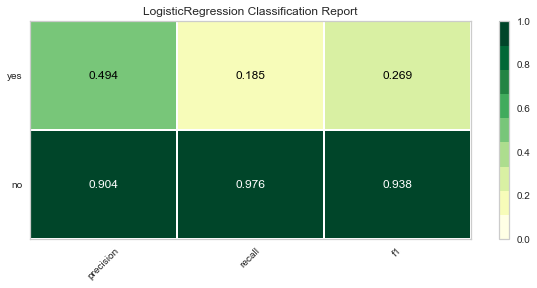

In [68]:
show_classification_rpt(logit)

In [69]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

          no       0.90      0.98      0.94      9132
         yes       0.49      0.18      0.27      1165

    accuracy                           0.89     10297
   macro avg       0.70      0.58      0.60     10297
weighted avg       0.86      0.89      0.86     10297



In [70]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_logit))

Confusion Matrix:
[[8912  220]
 [ 950  215]]


## Decision Tree

In [71]:
tree = DecisionTreeClassifier(random_state=rand_state)

In [72]:
print("Accuracy with Decision Tree", end=': ')
y_pred_tree = fit_predict(tree, X_train, X_test, y_train, y_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(tree_accuracy)

Accuracy with Decision Tree: 0.8520928425755074


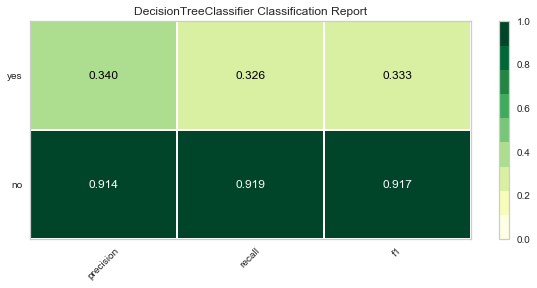

In [73]:
show_classification_rpt(tree)

In [74]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_tree))

Confusion Matrix:
[[8394  738]
 [ 785  380]]


### Hyper Parameter Tuning

In [75]:
def fit_predict_dt(train, test, y_train, y_test, scaler, max_depth,
               criterion = 'entropy', max_features=1, min_samples_split=4):
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    dt = DecisionTreeClassifier(criterion = criterion, max_depth=max_depth,
                               random_state= 101, max_features=max_features,
                               min_samples_split=min_samples_split)
    dt.fit(train_scaled, y_train)
    y_pred = dt.predict(test_scaled)
    return y_pred

### Max depth parameter tuning

In [76]:
list_max_depth = []

In [77]:
for i in range(1,30):
    print("Accuracy score using max_depth = ", i, end = ':')
    y_pred_tree_hpt = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), i)
    dt_max_depth = accuracy_score(y_test, y_pred_tree_hpt)
    print(dt_max_depth)
    list_max_depth.append(dt_max_depth)
    
max_depth_tuned = list_max_depth.index(max(list_max_depth))+1
print(max_depth_tuned)

Accuracy score using max_depth =  1:0.8868602505584151
Accuracy score using max_depth =  2:0.8868602505584151
Accuracy score using max_depth =  3:0.8869573662231718
Accuracy score using max_depth =  4:0.8862775565698747
Accuracy score using max_depth =  5:0.8855977469165777
Accuracy score using max_depth =  6:0.8865689035641449
Accuracy score using max_depth =  7:0.8879285228707391
Accuracy score using max_depth =  8:0.8897737205011168
Accuracy score using max_depth =  9:0.8908419928134408
Accuracy score using max_depth =  10:0.8944352724094397
Accuracy score using max_depth =  11:0.8880256385354958
Accuracy score using max_depth =  12:0.8850150529280373
Accuracy score using max_depth =  13:0.8917160337962513
Accuracy score using max_depth =  14:0.8896766048363601
Accuracy score using max_depth =  15:0.8888025638535496
Accuracy score using max_depth =  16:0.8843352432747402
Accuracy score using max_depth =  17:0.8837525492861998
Accuracy score using max_depth =  18:0.8877342915412256
A

### Max features tuning

In [78]:
dict_max_features = {}

In [79]:
for i in np.arange(0.1,1.0,0.1):
    print('Accuracy score using max features =', i, end = ":")
    y_pred_max_features = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=i)
    dt_max_features = accuracy_score(y_test, y_pred_max_features)
    print(dt_max_features)
    dict_max_features[i]=dt_max_features

max_feature_tuned = max(dict_max_features, key=dict_max_features.get)
print(max_feature_tuned)

Accuracy score using max features = 0.1:0.8954064290570068
Accuracy score using max features = 0.2:0.8956977760512771
Accuracy score using max features = 0.30000000000000004:0.8941439254151695
Accuracy score using max features = 0.4:0.8938525784208993
Accuracy score using max features = 0.5:0.8944352724094397
Accuracy score using max features = 0.6:0.8974458580168981
Accuracy score using max features = 0.7000000000000001:0.8946295037389531
Accuracy score using max features = 0.8:0.8906477614839273
Accuracy score using max features = 0.9:0.8946295037389531
0.6


### Min samples split tuning

In [80]:
dict_min_samples_split = {}

In [81]:
for i in range(2,10):
    print('Accuracy score using min samples split=', i, end=":")
    y_pred_min_split = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=max_feature_tuned, min_samples_split=i)
    dt_min_sample_split = accuracy_score(y_test, y_pred_min_split)
    print(dt_min_sample_split)
    dict_min_samples_split[i] = dt_min_sample_split
    
min_sample_split_tuned = max(dict_min_samples_split, key=dict_min_samples_split.get)
print(min_sample_split_tuned)

Accuracy score using min samples split= 2:0.8980285520054385
Accuracy score using min samples split= 3:0.8973487423521413
Accuracy score using min samples split= 4:0.8974458580168981
Accuracy score using min samples split= 5:0.8975429736816548
Accuracy score using min samples split= 6:0.8966689326988443
Accuracy score using min samples split= 7:0.8936583470913858
Accuracy score using min samples split= 8:0.8940468097504127
Accuracy score using min samples split= 9:0.8936583470913858
2


### Criterion tuning

In [82]:
dict_index_tuned = {}

In [83]:
for i in ['gini','entropy']:
    print("Accuracy score using criterion: ", i, end = ':')
    y_pred_index_score = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= i)
    dt_index_score = accuracy_score(y_test, y_pred_index_score)
    print(dt_index_score)
    dict_index_tuned[i] = dt_index_score

dt_index_tuned = max(dict_index_tuned, key=dict_index_tuned.get)
print(dt_index_tuned)

Accuracy score using criterion:  gini:0.8933670000971157
Accuracy score using criterion:  entropy:0.8980285520054385
entropy


### Rerunning decision tree with best parameters

In [84]:
tree_best_pred  =  fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= dt_index_tuned)
dt_best_param_score = accuracy_score(y_test, tree_best_pred)
print("Accuracy score for decision tree using best param: ", end = ':')
print(dt_best_param_score)

Accuracy score for decision tree using best param: :0.8980285520054385


In [85]:
tree1 = DecisionTreeClassifier(criterion = dt_index_tuned, max_depth=max_depth_tuned,
                               random_state= rand_state, max_features=max_feature_tuned,
                               min_samples_split=min_sample_split_tuned)

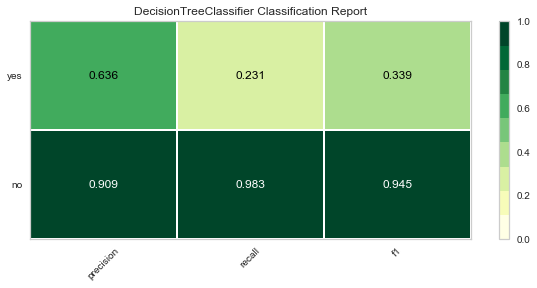

In [86]:
show_classification_rpt(tree1)

In [87]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, tree_best_pred))

Confusion Matrix:
[[8978  154]
 [ 896  269]]


### Using polynomial features

In [88]:
def create_poly(train, test, degree):
    poly = PolynomialFeatures(degree = degree)
    train_poly = poly.fit_transform(train)
    test_poly = poly.fit_transform(test)
    return train_poly, test_poly

In [89]:
## polynomial features taking a lot of time as the number of columns are more. Hence commented the following piece of code

In [90]:
# for degree in [1,2,3,4]:
#     train_poly, test_poly = create_poly(X_train, X_test, degree)
#     print("polynomial degree", degree)
#     fit_predict(train_poly, test_poly, y_train, y_test, StandardScaler(), 16, max_features = 0.2,min_samples_split=4, criterion='entropy')
#     print(10 *'-')

## Random Forest

In [91]:
forest = RandomForestClassifier(criterion='entropy', oob_score=True)

In [92]:
print("Accuracy with Random Forest", end=': ')
rf_pred = fit_predict(forest, X_train, X_test, y_train, y_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(rf_accuracy)

Accuracy with Random Forest: 0.8917160337962513


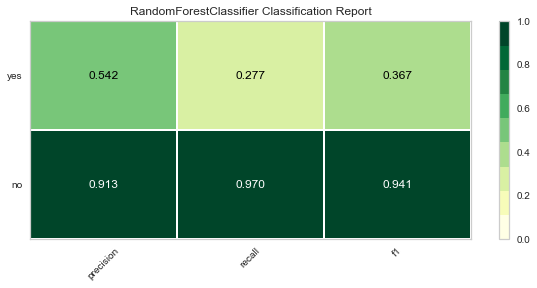

In [93]:
show_classification_rpt(forest)

In [94]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,rf_pred))

Confusion Matrix:
[[8859  273]
 [ 842  323]]


### Parameter tuning using Grid Search

In [95]:
params = {
    'n_estimators': [200,500,700],
    'max_depth': [10,15,20,25],
    'min_samples_leaf': [3,5,7]
}

In [96]:
gs = GridSearchCV(forest, params, cv=cv, verbose=verbose, n_jobs=number_of_jobs)

In [97]:
if grid_search_enable == True:
    gs.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.0min finished


In [98]:
if grid_search_enable == True:
    print(gs.best_params_)

{'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 700}


In [99]:
if grid_search_enable == True:
    forest_best_max_depth = gs.best_params_['max_depth']
    forest_best_min_samples = gs.best_params_['min_samples_leaf']
    forest_best_n_estimators = gs.best_params_['n_estimators']
    #forest_best_criterion = gs.best_params_['criterion']

In [100]:
if grid_search_enable == True:
    print(gs.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)


### Retraining with best estimators

In [101]:
if grid_search_enable == True:
    forest1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=forest_best_max_depth, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=forest_best_min_samples, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=forest_best_n_estimators,
                       n_jobs=number_of_jobs, oob_score=True, random_state=rand_state,
                       verbose=0, warm_start=False)

In [102]:
if grid_search_enable == True:
    forest1.fit(X_train, y_train)

In [103]:
if grid_search_enable == True:
    pred_forest1 = forest1.predict(X_test)

In [104]:
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    rf_hyper_accuracy = accuracy_score(y_test, pred_forest1)
    print(rf_hyper_accuracy)

Accuracy with Random Forest after Hyper Parameter Tuning: 0.9009420219481402


In [105]:
if grid_search_enable == True:
    for x in sorted(list(zip(forest1.feature_importances_, X_train.columns)), reverse=True):
        print(x)

(0.14925725328414763, 'euribor3m')
(0.09579063342759819, 'f.euribor_lt_1')
(0.09377497339138355, 'f.recession_strength')
(0.0729485417417059, 'f.euribor_gt_4')
(0.06368297111410848, 'cons.price.idx')
(0.03400071464117064, 'poutcome_failure')
(0.03235837236980373, 'f.pattern_no')
(0.03217476622347647, 'poutcome_success')
(0.023300877880816046, 'f.euribor_gt_1_lt_2')
(0.021126414507539746, 'month_may')
(0.018241226106344575, 'previous')
(0.017791085059367346, 'contact_cellular')
(0.017249382591249297, 'contact_telephone')
(0.015615302645549283, 'f.age_weightage')
(0.015492414271753312, 'f.user_type_new user')
(0.014333082063357394, 'f.seasons_spring')
(0.013780649788191475, 'f.user_type_existing user')
(0.013557234744243784, 'f.previous_campaigns_no previous')
(0.012746788572918201, 'f.season_weight')
(0.011262539860711521, 'f.first_time_user_calls_returning user')
(0.009940530971051634, 'month_oct')
(0.00940235334188973, 'campaign')
(0.008967075724437211, 'f.avg_income_dist')
(0.0087774

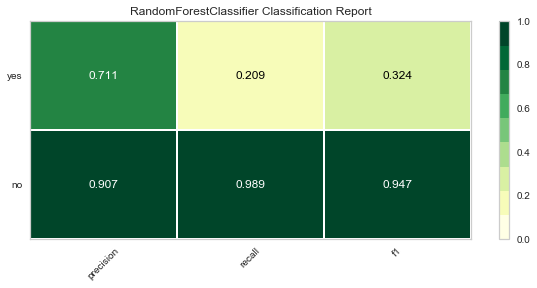

In [106]:
if grid_search_enable == True:
    show_classification_rpt(forest1)

In [107]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, pred_forest1))

Confusion Matrix:
[[9033   99]
 [ 921  244]]


## Accuracy Summary Without Boosting

In [108]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)
print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy of Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)
print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    print(rf_hyper_accuracy)

Accuracy with Logistic Regression: 0.8863746722346314
Accuracy with Decision Tree: 0.8520928425755074
Accuracy of Decision Tree after Hyper Parameter Tuning: :0.8980285520054385
Accuracy with Random Forest: 0.8917160337962513
Accuracy with Random Forest after Hyper Parameter Tuning: 0.9009420219481402


## AdaBoost

In [109]:
from sklearn.ensemble import AdaBoostClassifier

In [110]:
adabst_fit = AdaBoostClassifier(base_estimator=logit, random_state=rand_state, n_estimators=100)

In [111]:
adabst_fit.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   learning_rate=1.0, n_estimators=100, random_state=101)

In [112]:
print("Accuracy with Ada Boost", end=': ')
ada_boost_predict = adabst_fit.predict(X_test)
ada_boost_accuracy = accuracy_score(y_test,ada_boost_predict)
print(ada_boost_accuracy)

Accuracy with Ada Boost: 0.8888025638535496


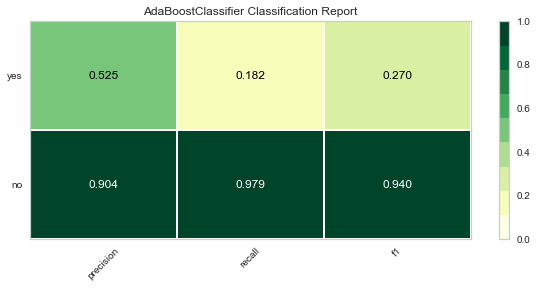

In [113]:
show_classification_rpt(adabst_fit)

In [114]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, ada_boost_predict))

Confusion Matrix:
[[8940  192]
 [ 953  212]]


### Adaboost with Grid Search

In [115]:
params_adaboost = {
    'n_estimators': [100,200,300],
    'base_estimator': [logit, tree1],
    'learning_rate': [0.5,0.75,1.0]
}

In [116]:
ada_gs = GridSearchCV(adabst_fit, params_adaboost, cv=cv, n_jobs=number_of_jobs)

In [117]:
if grid_search_enable == True:
    ada_gs.fit(X_train, y_train)

In [118]:
if grid_search_enable == True:
    adabst_best_estimator = ada_gs.best_params_['base_estimator']
    adabst_best_learning_rate = ada_gs.best_params_['learning_rate']
    adabst_best_n_estimators = ada_gs.best_params_['n_estimators']

In [119]:
if grid_search_enable == True:
    ada_gs.best_params_

### Adaboost - Retraining with best estimators

In [120]:
if grid_search_enable == True:
    ada_best = AdaBoostClassifier(base_estimator=adabst_best_estimator, random_state=rand_state,
                                  n_estimators=adabst_best_n_estimators, learning_rate=adabst_best_learning_rate)

In [121]:
if grid_search_enable == True:
    ada_best.fit(X_train, y_train)
    ada_best_predict = ada_best.predict(X_test)

In [122]:
if grid_search_enable == True:
    print("Accuracy with Adaboost after Hyper Parameter Tuning", end=': ')
    ada_best_hyper_accuracy = accuracy_score(y_test, ada_best_predict)
    print(ada_best_hyper_accuracy)

Accuracy with Adaboost after Hyper Parameter Tuning: 0.8903564144896572


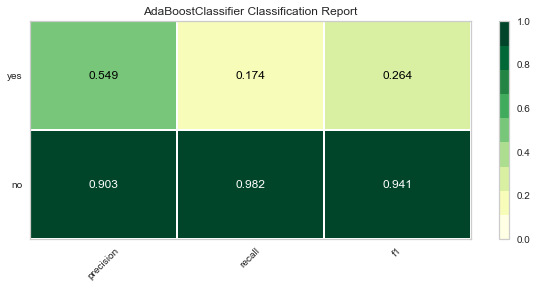

In [123]:
if grid_search_enable == True:
    show_classification_rpt(ada_best)

In [126]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, ada_best_predict))

Confusion Matrix:
[[8965  167]
 [ 962  203]]


## Gradient Boost

In [127]:
from sklearn.ensemble import GradientBoostingClassifier

In [128]:
gbc_fit = GradientBoostingClassifier(n_estimators=500,
                                     min_samples_split=2,min_samples_leaf=1,max_depth=1,random_state=rand_state)

In [129]:
gbc_fit.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=101, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [130]:
print("Accuracy with Gradient Boost", end=': ')
y_pred_gbc = gbc_fit.predict(X_test)
gbc_accuracy = accuracy_score(y_test, y_pred_gbc)
print(gbc_accuracy)

Accuracy with Gradient Boost: 0.8989997086530057


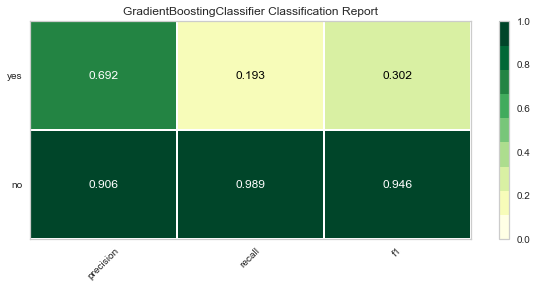

In [132]:
show_classification_rpt(gbc_fit)

In [133]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))

Confusion Matrix:
[[9032  100]
 [ 940  225]]


### Gradient boost with Grid Search

In [134]:
params_gbc = {
    'n_estimators': [100,300,500],
    'max_depth': [2,3,4],
    'learning_rate': [0.05,0.075,0.1]
}

In [135]:
gbc_gs = GridSearchCV(gbc_fit, params_gbc, cv=cv, n_jobs=number_of_jobs)

In [136]:
if grid_search_enable == True:
    gbc_gs.fit(X_train, y_train)

In [137]:
if grid_search_enable == True:
    gbc_best_estimator = gbc_gs.best_params_['n_estimators']
    gbc_best_max_depth = gbc_gs.best_params_['max_depth']
    gbc_best_learning_rate = gbc_gs.best_params_['learning_rate']

In [138]:
if grid_search_enable == True:
    print(gbc_gs.best_params_)

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


### Gradient Boost - With Best Parameters

In [139]:
if grid_search_enable == True:
    gbc_best = GradientBoostingClassifier(n_estimators=gbc_best_estimator,
                                     min_samples_split=2,min_samples_leaf=1,max_depth=gbc_best_max_depth,random_state=rand_state,
                                         learning_rate=gbc_best_learning_rate)

In [140]:
if grid_search_enable == True:
    gbc_best.fit(X_train, y_train)
    gbc_best_predict = gbc_best.predict(X_test)

In [141]:
if grid_search_enable == True:
    print("Accuracy with Gradient Boost after Hyper Parameter Tuning", end=': ')
    gbc_best_hyper_accuracy = accuracy_score(y_test, gbc_best_predict)
    print(gbc_best_hyper_accuracy)

Accuracy with Gradient Boost after Hyper Parameter Tuning: 0.9007477906186268


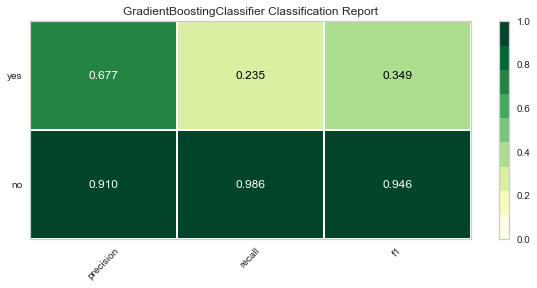

In [142]:
if grid_search_enable == True:
    show_classification_rpt(gbc_best)

In [143]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, gbc_best_predict))

Confusion Matrix:
[[9001  131]
 [ 891  274]]


## LGBM

In [144]:
from lightgbm import LGBMClassifier

In [145]:
LGBM = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=31)
LGBM.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [146]:
LGBM_predict = LGBM.predict(X_test)

In [147]:
print("Accuracy with LGBM", end=': ')
lgbm_accuracy = accuracy_score(y_test,LGBM_predict)
print(lgbm_accuracy)

Accuracy with LGBM: 0.9024958725842478


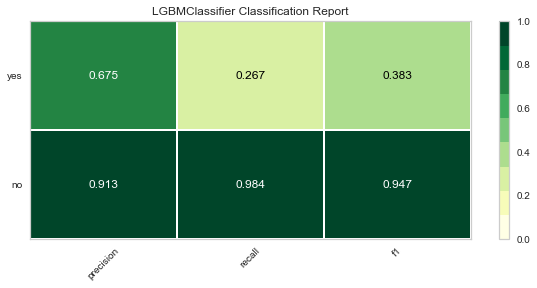

In [148]:
show_classification_rpt(LGBM)

In [149]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, LGBM_predict))

Confusion Matrix:
[[8982  150]
 [ 854  311]]


### LGBM With Grid Search

In [150]:
lgbm_params = {
    'num_leaves': [31,35,41,45],
    'learning_rate':[0.03,0.05,0.07,0.09],
    'n_estimators': [50,75,100,150]
}

In [151]:
if grid_search_enable == True:
    lgbm_gs = GridSearchCV(LGBM, lgbm_params, cv=cv, n_jobs=number_of_jobs)
    lgbm_gs.fit(X_train, y_train)

In [152]:
if grid_search_enable == True:
    lgbm_best_estimator = lgbm_gs.best_params_['n_estimators']
    lgbm_best_learning_rate = lgbm_gs.best_params_['learning_rate']
    lgbm_best_num_leaves = lgbm_gs.best_params_['num_leaves']
    print(lgbm_gs.best_params_)

{'learning_rate': 0.07, 'n_estimators': 50, 'num_leaves': 31}


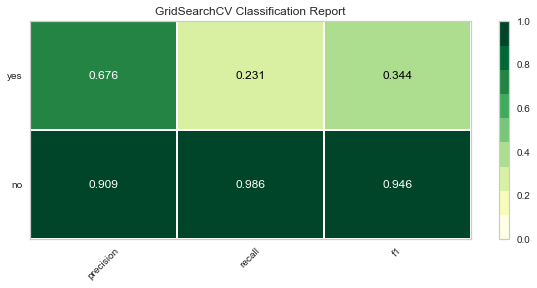

In [153]:
if grid_search_enable == True:
    show_classification_rpt(lgbm_gs)

### LGBM With Best Parameters

In [155]:
if grid_search_enable == True:
    LGBM_best = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=lgbm_best_num_leaves, 
                               learning_rate=lgbm_best_learning_rate, n_estimators=lgbm_best_estimator)
    LGBM_best.fit(X_train, y_train)

In [156]:
if grid_search_enable == True:
    LGBM_best_predict = LGBM_best.predict(X_test)
    LGBM_accuracy_score = accuracy_score(y_test,LGBM_best_predict)

In [157]:
if grid_search_enable == True:
    print("Accuracy with LGBM with Hyper Parameter Tuning", end=': ')
    print(LGBM_accuracy_score)

Accuracy with LGBM with Hyper Parameter Tuning: 0.9004564436243566


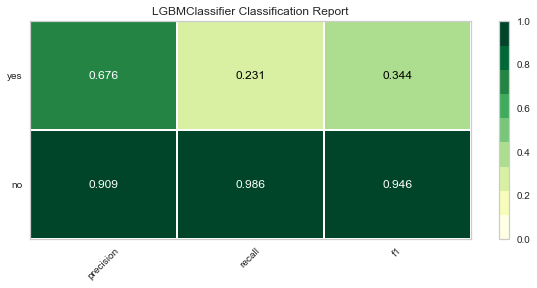

In [158]:
if grid_search_enable == True:
    show_classification_rpt(LGBM_best)

In [159]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, LGBM_best_predict))

Confusion Matrix:
[[9003  129]
 [ 896  269]]


## XG Boost

In [160]:
from xgboost import XGBClassifier

In [161]:
xgb_fit = XGBClassifier(max_depth=2, n_estimators=5000, random_state=rand_state, n_jobs=number_of_jobs)
xgb_fit.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [162]:
print("Accuracy with XG Boost", end=': ')
xgb_predict = xgb_fit.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_predict)
print(xgb_accuracy)

Accuracy with XG Boost: 0.8973487423521413


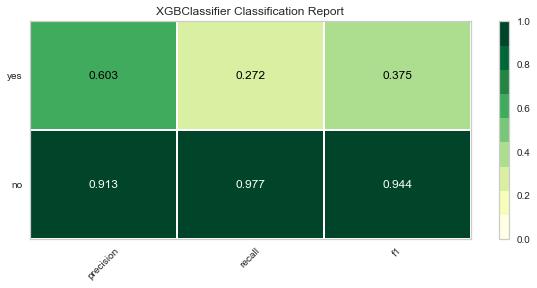

In [163]:
show_classification_rpt(xgb_fit)

In [164]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_predict))

Confusion Matrix:
[[8923  209]
 [ 848  317]]


### XG Boost with Grid Search

In [165]:
xgb_params = {
    'max_depth': [2,3,4],
    'n_estimators': [300,500,700],
    'learning_rate': [0.05,0.075,0.1]
}

In [166]:
xgb_gs = GridSearchCV(xgb_fit, xgb_params, cv=cv, n_jobs=number_of_jobs)

In [167]:
if grid_search_enable == True:
    xgb_gs.fit(X_train, y_train)

In [168]:
if grid_search_enable == True:
    print(xgb_gs.best_params_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}


In [169]:
if grid_search_enable == True:
    xgb_best_max_depth = xgb_gs.best_params_['max_depth']
    xgb_best_n_estimators = xgb_gs.best_params_['n_estimators']
    xgb_best_learning_rate = xgb_gs.best_params_['learning_rate']

### Re-running XG Boost with Best Parameters

In [170]:
if grid_search_enable == True:
    xgb_best = XGBClassifier(max_depth=xgb_best_max_depth,
                             n_estimators=xgb_best_n_estimators, random_state=rand_state,
                             n_jobs=number_of_jobs, learning_rate = xgb_best_learning_rate)
    xgb_best.fit(X_train, y_train)
    xgb_best_predict = xgb_best.predict(X_test)

In [171]:
if grid_search_enable == True:
    print("Accuracy with XG Boost after Hyper Parameter Tuning", end=': ')
    xgb_best_hyper_accuracy = accuracy_score(y_test, xgb_best_predict)
    print(xgb_best_hyper_accuracy)

Accuracy with XG Boost after Hyper Parameter Tuning: 0.9005535592891133


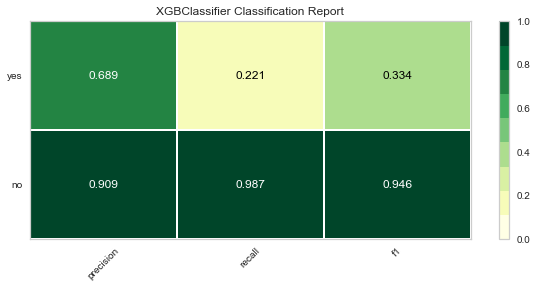

In [172]:
if grid_search_enable == True:
    show_classification_rpt(xgb_best)

In [173]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, xgb_best_predict))

Confusion Matrix:
[[9016  116]
 [ 908  257]]


## Accuracy Summary With Boosting

In [175]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)

print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy with Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)

print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    print(rf_hyper_accuracy)

print("Accuracy with Ada Boost", end=': ')
print(ada_boost_accuracy)
if grid_search_enable == True:
    print("Accuracy with Ada Boost after Hyper Parameter Tuning", end=': ')
    print(ada_best_hyper_accuracy)

print("Accuracy with Gradient Boost", end=': ')
print(gbc_accuracy)
if grid_search_enable == True:
    print("Accuracy with Gradient Boost after Hyper Parameter Tuning", end=': ')
    print(gbc_best_hyper_accuracy)
    
print("Accuracy with LGBM", end=': ')
print(lgbm_accuracy)
if grid_search_enable == True:
    print("Accuracy with LGBM after Hyper Parameter Tuning", end=': ')
    print(LGBM_accuracy_score)
    
print("Accuracy with XG Boost", end=': ')
print(xgb_accuracy)
if grid_search_enable == True:
    print("Accuracy with XG Boost after Hyper Parameter Tuning", end=': ')
    print(xgb_best_hyper_accuracy)

Accuracy with Logistic Regression: 0.8863746722346314
Accuracy with Decision Tree: 0.8520928425755074
Accuracy with Decision Tree after Hyper Parameter Tuning: :0.8980285520054385
Accuracy with Random Forest: 0.8917160337962513
Accuracy with Random Forest after Hyper Parameter Tuning: 0.9009420219481402
Accuracy with Ada Boost: 0.8888025638535496
Accuracy with Ada Boost after Hyper Parameter Tuning: 0.8903564144896572
Accuracy with Gradient Boost: 0.8989997086530057
Accuracy with Gradient Boost after Hyper Parameter Tuning: 0.9007477906186268
Accuracy with LGBM: 0.9024958725842478
Accuracy with LGBM after Hyper Parameter Tuning: 0.9004564436243566
Accuracy with XG Boost: 0.8973487423521413
Accuracy with XG Boost after Hyper Parameter Tuning: 0.9005535592891133
